<img src="REcoM.png" alt="Drawing" style="width: 900px; margin: 0 auto">
<p style="text-align: center;">This notebook is an extensive demonstration of the *py_recom* module. *py_recom* is a tool for the evaluation of REcoM model outputs.</p>

### Table of Contents

* [0. Configuration](#CONFIG)
        
* [2. Nutrients and Oxygen](#BGC)
    * [2.1 Maps](#BGCMAPS)
        * [2.1.1 DO2](#OXYMAP)
        * [2.1.2 DIN](#DINMAP)
        * [2.1.3 DSi](#DSIMAP)
        * [2.1.3 DFe](#DFEMAP)
    * [2.2 Time-series](#BGCTS)
        * [2.2.2 DIN](#DINTS)
        * [2.2.3 DSi](#DSITS)
        * [2.2.3 DFe](#DFETS)
    * [2.3 Profiles](#BGCPRO)

# 0. Configuration<a class="anchor" id="CONFIG"></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')
%autosave 5

# necessary modules -------------------------------------------------------------------------------------
import socket
import sys
import os
home = os.path.expanduser("~")
sys.path.append(home+'/py_f2recom/GlobalAssessment/')
sys.path.append(home+ '/py_f2recom/modules/')
sys.path.append(home+ '/py_f2recom/modules/pyfesom2')
sys.path.append(home+ '/py_f2recom/modules/cmocean-master/')
sys.path.append(home+'/py_f2recom/modules/SkillMetrics/')
import pyfesom2 as pf
import skill_metrics as sm
import cmocean as cmo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from datetime import date
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from netCDF4 import Dataset

Autosaving every 5 seconds
osgeo is not installed, conversion to Geo formats like Geotiff (fesom2GeoFormat) will not work.


In [2]:
#    Only modify parameters and paths in this cell       #
#  In principle, you don't have to modify anything else  #


# run specification -------------------------------------------------------------------------------------   
simu_name = 'A' # only usefull if you want to save figures

# defines paths ----------------------------------------------------------------------------------------- 

if socket.gethostname()[:5] == 'blogi':
    meshpath = '/scratch/usr/hbkoziel/mesh/farc'
    resultpath = '/scratch/projects/hbk00083/model_outputs/fesom2.1_recom'+simu_name+'/'
    savepath = home+'/pyfesom2/codes/py_f2recom_develop/outputs/'+simu_name+'/'
    evalpath      = '/scratch/usr/hbkoziel/evaluation/'
    evalpath2      = '/scratch/usr/hbkoziel/corrected_input/'
elif socket.gethostname()[:5] in ['albed','prod-']:
    #resultpath = '/albedo/work/projects/p_bio/model_output/A_riv'
    resultpath = '/albedo/work/projects/MarESys/GCB2022/A'
    savepath = home+'/py_f2recom/outputs/'+simu_name+'/'
    evalpath = '/albedo/work/projects/p_pool_recom/eval/'
    meshpath = '/albedo/work/projects/p_bio/mesh/core2/'
    #meshpath = '/albedo/work/user/yye/fesom2/meshes/core2_albedo/'
else:
    print('sorry, machine unknown, please customize your paths yourself')

# period of analysis ------------------------------------------------------------------------------------
first_year_maps = 2012
first_year = 2012
last_year  = 2021
    
years = np.arange(first_year,last_year+1,1)
years_last10 = np.arange(first_year_maps,last_year+1,1)

# specification of analysis ------------------------------------------------------------------------------------
layerwise = False
depths = (0,50,200,1000,2000) # If layerwise is True, you can define depths here, by defaut: (0,50,200,1000,2000,4000)
uplow = [0, 100]
mapproj = 'rob'
# Map projection ptions are : Mercator (merc), Plate Carree (pc),
# North Polar Stereo (np), South Polar Stereo (sp),  Robinson (rob)
# Robinson projection is quite time consuming.

In [3]:
# export of analysis ------------------------------------------------------------------------------------
# Be aware that exporting figures may alter (crop) the display but the printed figures are okay
# This is because of bugs in the 'constrained_layout' matplotlib experimental function 
# that may be fixed in the future matplotlib version but out of our control
# If you prefer having a nice HTML, savefig must be turned off
#--------------------------------------------------------------------------------------------------------
today = date.today().strftime("_%Y_%m_%d")
savefig = True 
htmlname     =  simu_name+'_'+ today +'_nuts_o2.html'
htmlpath = savepath
verbose = True

if not os.path.exists(htmlpath): # create folders if do not exist
    os.makedirs(htmlpath)
if not os.path.exists(savepath):
    os.makedirs(savepath)
    
# initialization file specifications -----------------------------------------------------------
ncfileDSi                = evalpath+'data/woa13_all_i00_01_fesom2.nc'
ncfileDIN                = evalpath+'data/woa13_all_n00_01_fesom2.nc'
ncfileDO2                = evalpath+'data/woa18_all_o00_01_mmol_fesom2.nc'
ncfileDFe_pisces         = evalpath+'fe_pisces_opa_eq_init_3D.nc' 
ncfileDFe_Huangetal      = evalpath+'Monthly_dFe_Huang2021.nc' 

# visual check
if(verbose):
    print('Processing years {4} to {5}\n\nReading out of {0}\nStoring graphs to {1}\nStoring html to {2} as {3}'.format(
        resultpath, savepath, htmlpath, htmlname,years[0],years[-1]))
    print('\nLast ten years are \n{0}'.format(years_last10))
    
# mesh initialization -----------------------------------------------------------
mesh = pf.load_mesh(meshpath)
mesh.path = meshpath

# export toolbox
!jupyter nbconvert --to=python Py_f2recom_toolbox.ipynb

Processing years 2012 to 2021

Reading out of /albedo/work/projects/MarESys/GCB2022/A
Storing graphs to /albedo/home/loziel/py_f2recom/outputs/A/
Storing html to /albedo/home/loziel/py_f2recom/outputs/A/ as A__2024_02_19_nuts_o2.html

Last ten years are 
[2012 2013 2014 2015 2016 2017 2018 2019 2020 2021]
/albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /albedo/work/projects/p_bio/mesh/core2/pickle_mesh_py3_fesom2
[NbConvertApp] Converting notebook Py_f2recom_toolbox.ipynb to python
[NbConvertApp] Writing 48324 bytes to Py_f2recom_toolbox.py


## 2. BGC tracers<a class="anchor" id="BGC"></a>

## 2.1 Maps<a class="anchor" id="BGCMAPS"></a>

## 2.1.1 DO2<a class="anchor" id="OXYMAP"></a>

[NbConvertApp] Converting notebook load_interp_WOA.ipynb to python
[NbConvertApp] Writing 7253 bytes to load_interp_WOA.py
[NbConvertApp] Converting notebook DO2_WOA.ipynb to python
[NbConvertApp] Writing 16655 bytes to DO2_WOA.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_all_o00_01_mmol_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: 0.0, Lower depth: -10.0
Upper depth: 0.0, Lower depth: -10.0

FESOM mean = 276.9131, std = 53.5083, min = 157.9611, max = 367.7609
PISCES mean = 292.4587, std = 67.7381, min = 175.8675, max = 479.3693


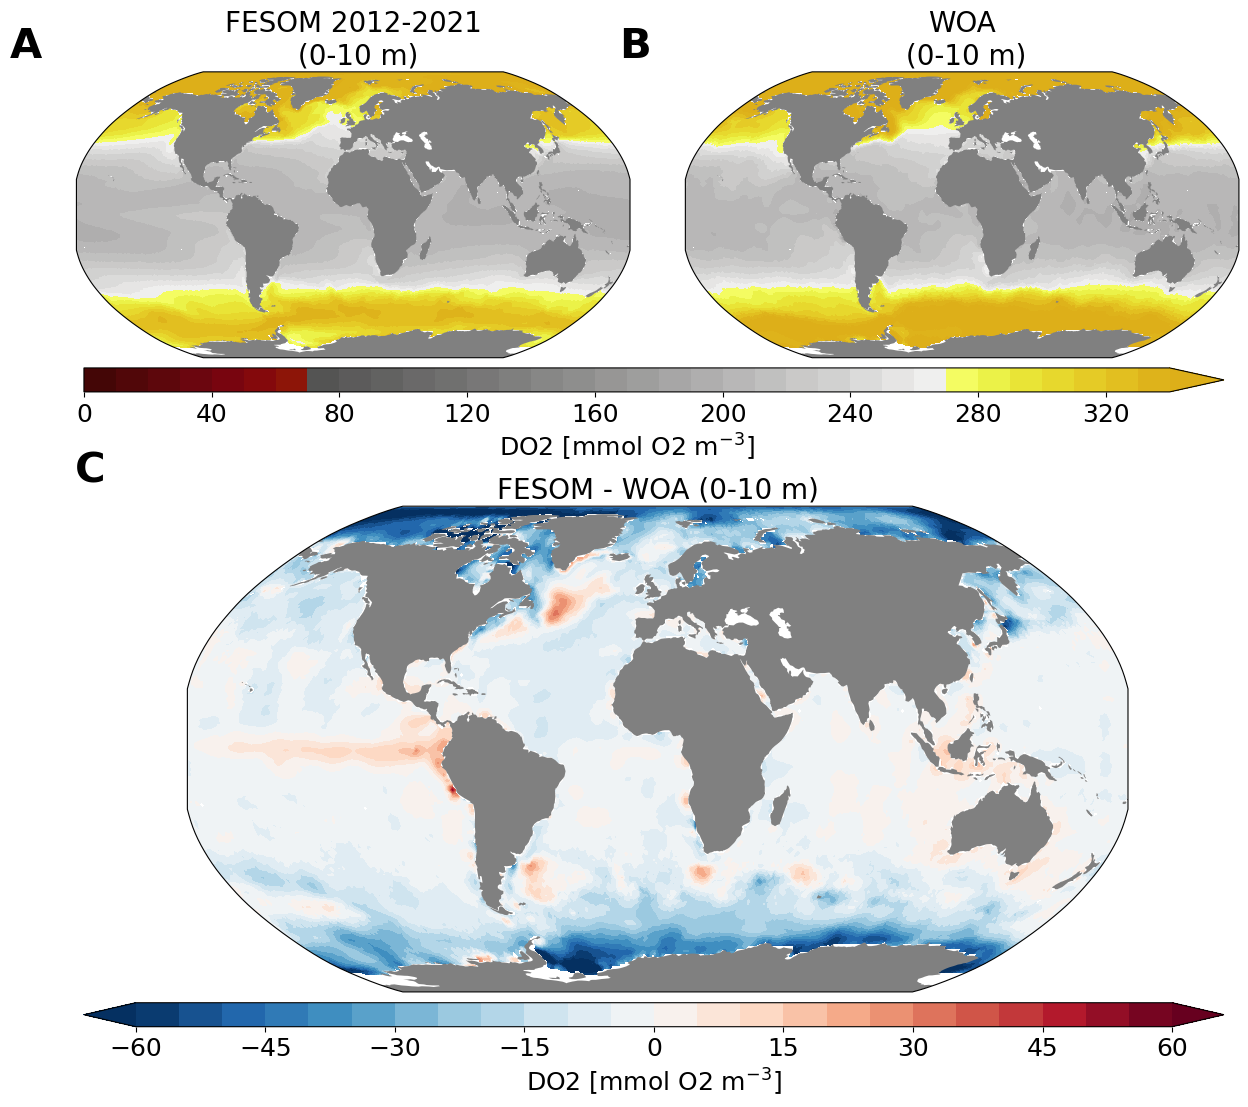


Original Taylor stats:
SDEV pred: 53.50828, ref: 67.73806
CRMS pred: 19.55731, ref: 0.00000
CORRCOEF: 0.97517

Normalized Taylor stats:
SDEV pred: 0.78993, ref: 1.00000
CRMS pred: 0.28872, ref: 0.00000
CORRCOEF: 0.97517


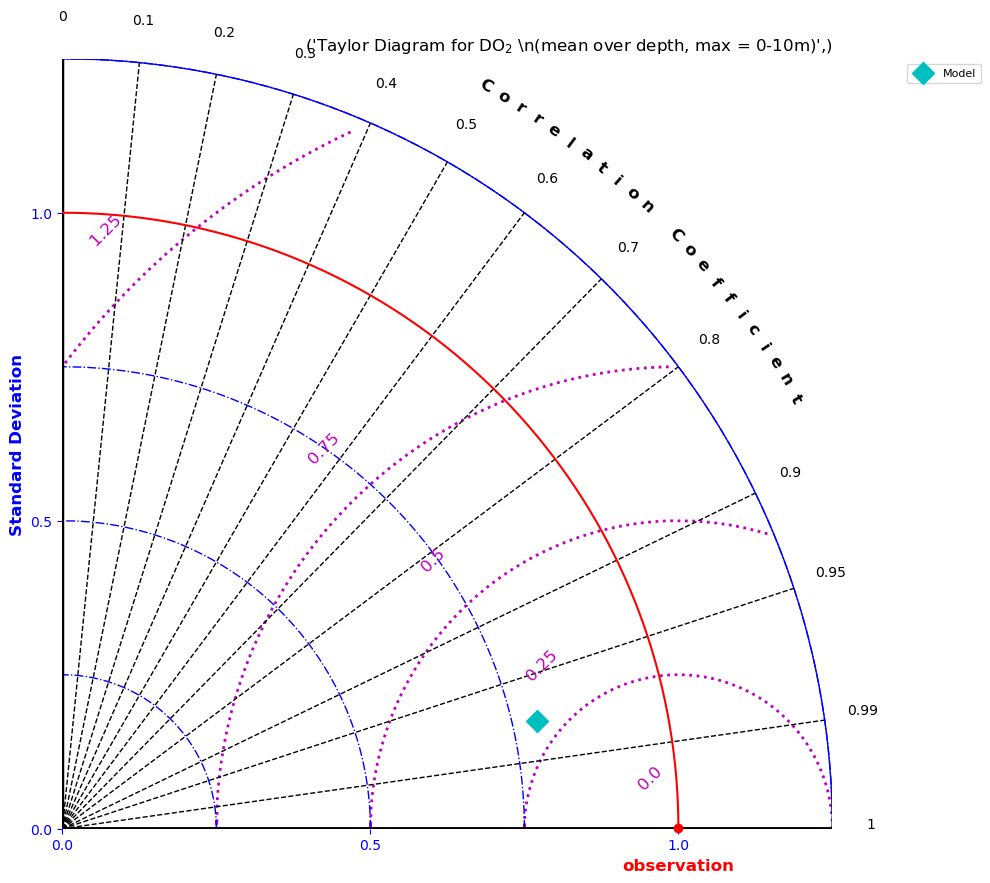

In [4]:
!jupyter nbconvert --to=python load_interp_WOA.ipynb
!jupyter nbconvert --to=python DO2_WOA.ipynb
from DO2_WOA import DO2comp

DO2comp(resultpath,savepath,mesh,ncfileDO2,first_year_maps,last_year,
               mapproj=mapproj,layerwise=layerwise,savefig=savefig,
               cmap=cmo.cm.oxy,verbose=verbose, uplow = [0, 10])

***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_all_o00_01_mmol_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: -280.0, Lower depth: -490.0
Upper depth: -280.0, Lower depth: -490.0

FESOM mean = 137.9025, std = 113.9761, min = -0.0032, max = 316.0695
PISCES mean = 130.6006, std = 109.9605, min = -0.0000, max = 331.5502


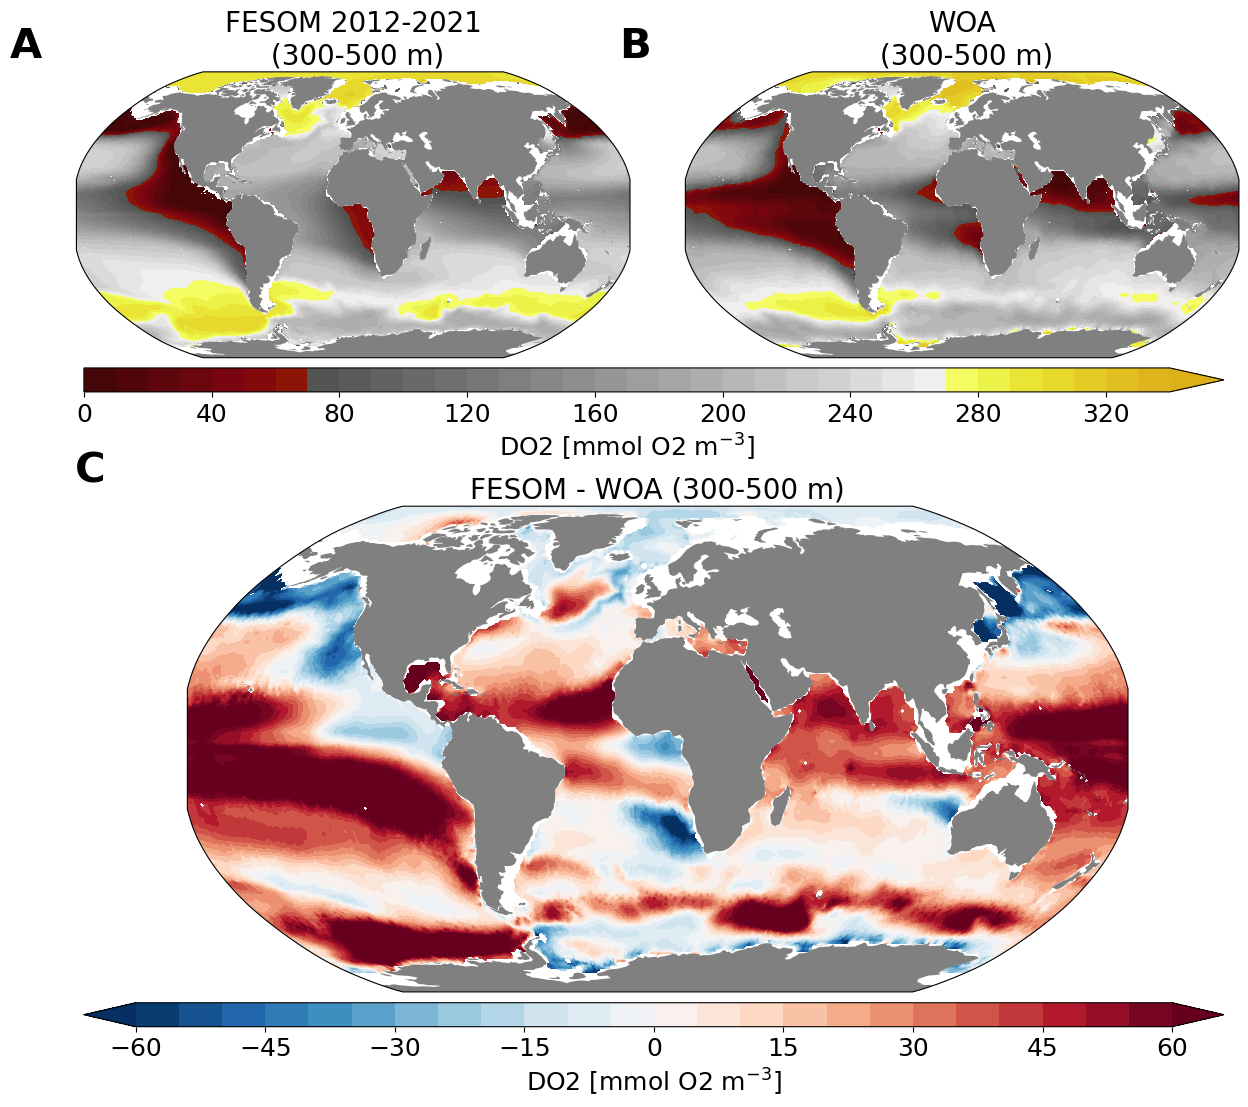


Original Taylor stats:
SDEV pred: 95.48206, ref: 93.58258
CRMS pred: 38.20069, ref: 0.00000
CORRCOEF: 0.91854

Normalized Taylor stats:
SDEV pred: 1.02030, ref: 1.00000
CRMS pred: 0.40820, ref: 0.00000
CORRCOEF: 0.91854
Adjust axis max to 1.5


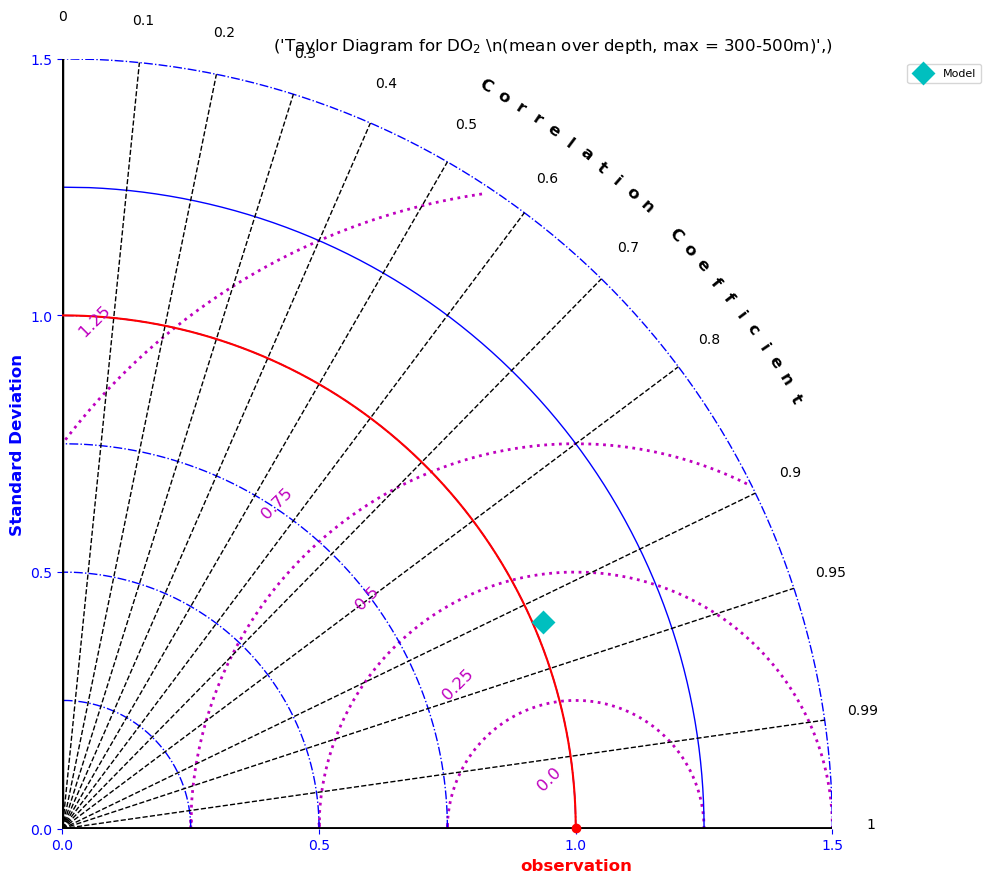

In [7]:
DO2comp(resultpath,savepath,mesh,ncfileDO2,first_year_maps,last_year,
               mapproj=mapproj,layerwise=layerwise,savefig=savefig,
               cmap=cmo.cm.oxy,verbose=verbose, uplow = [300, 500],
               )

***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_all_o00_01_mmol_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: -100.0, Lower depth: -580.0
Upper depth: -100.0, Lower depth: -580.0

FESOM mean = 147.8169, std = 107.6177, min = -0.0023, max = 314.1491
PISCES mean = 143.1109, std = 104.1426, min = -0.0000, max = 330.4656


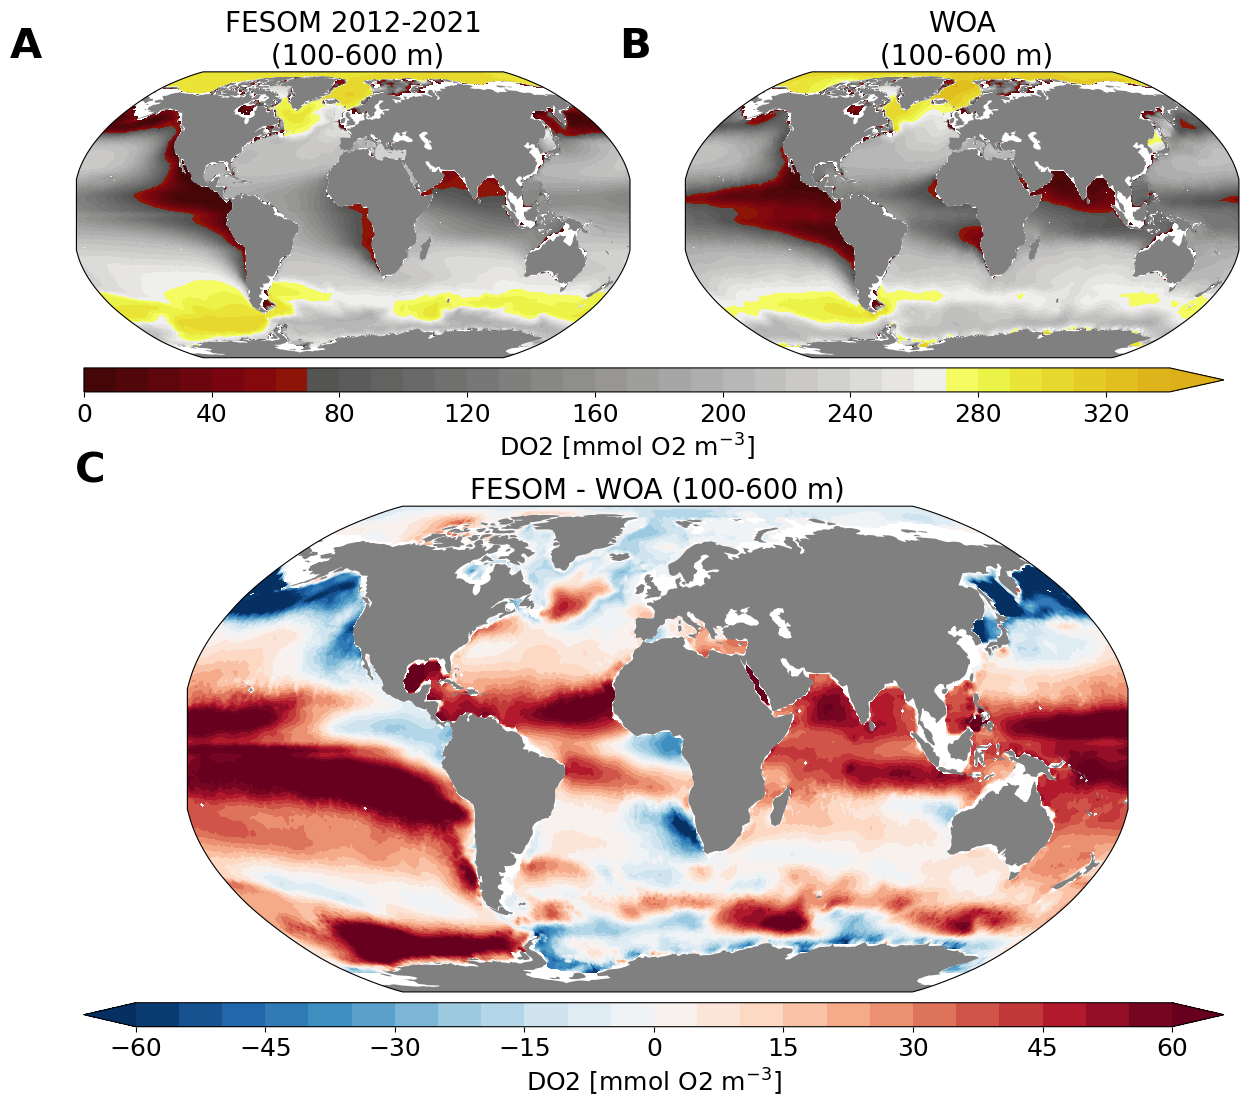


Original Taylor stats:
SDEV pred: 94.58361, ref: 91.50656
CRMS pred: 36.45972, ref: 0.00000
CORRCOEF: 0.92375

Normalized Taylor stats:
SDEV pred: 1.03363, ref: 1.00000
CRMS pred: 0.39844, ref: 0.00000
CORRCOEF: 0.92375
Adjust axis max to 1.5


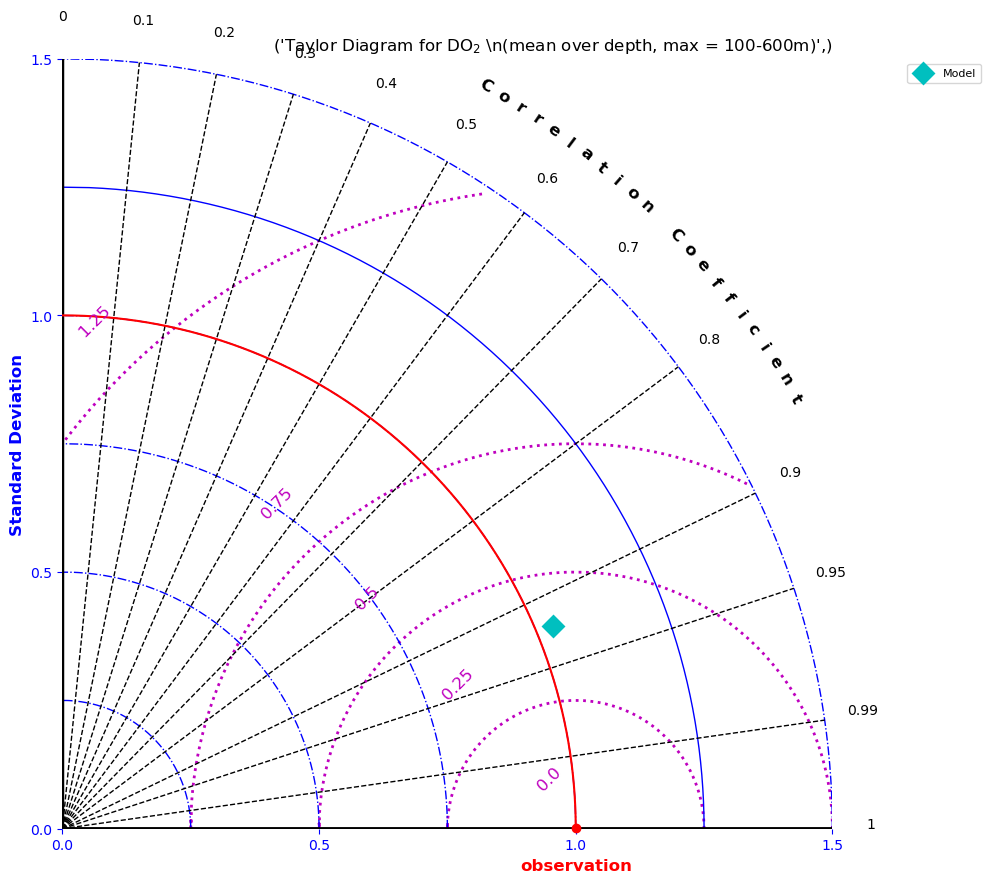

In [6]:
DO2comp(resultpath,savepath,mesh,ncfileDO2,first_year_maps,last_year,
               mapproj=mapproj,layerwise=layerwise,savefig=savefig,
               cmap=cmo.cm.oxy,verbose=True, uplow = [100,600],
               )

### 2.1.2 DIN<a class="anchor" id="DINMAP"></a>

[NbConvertApp] Converting notebook DIN_WOA.ipynb to python
[NbConvertApp] Writing 16324 bytes to DIN_WOA.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa13_all_n00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 7.3077, std = 8.4956, min = 0.0118, max = 42.8760
WOA mean = 9.1405, std = 8.8595, min = 0.0024, max = 33.1955


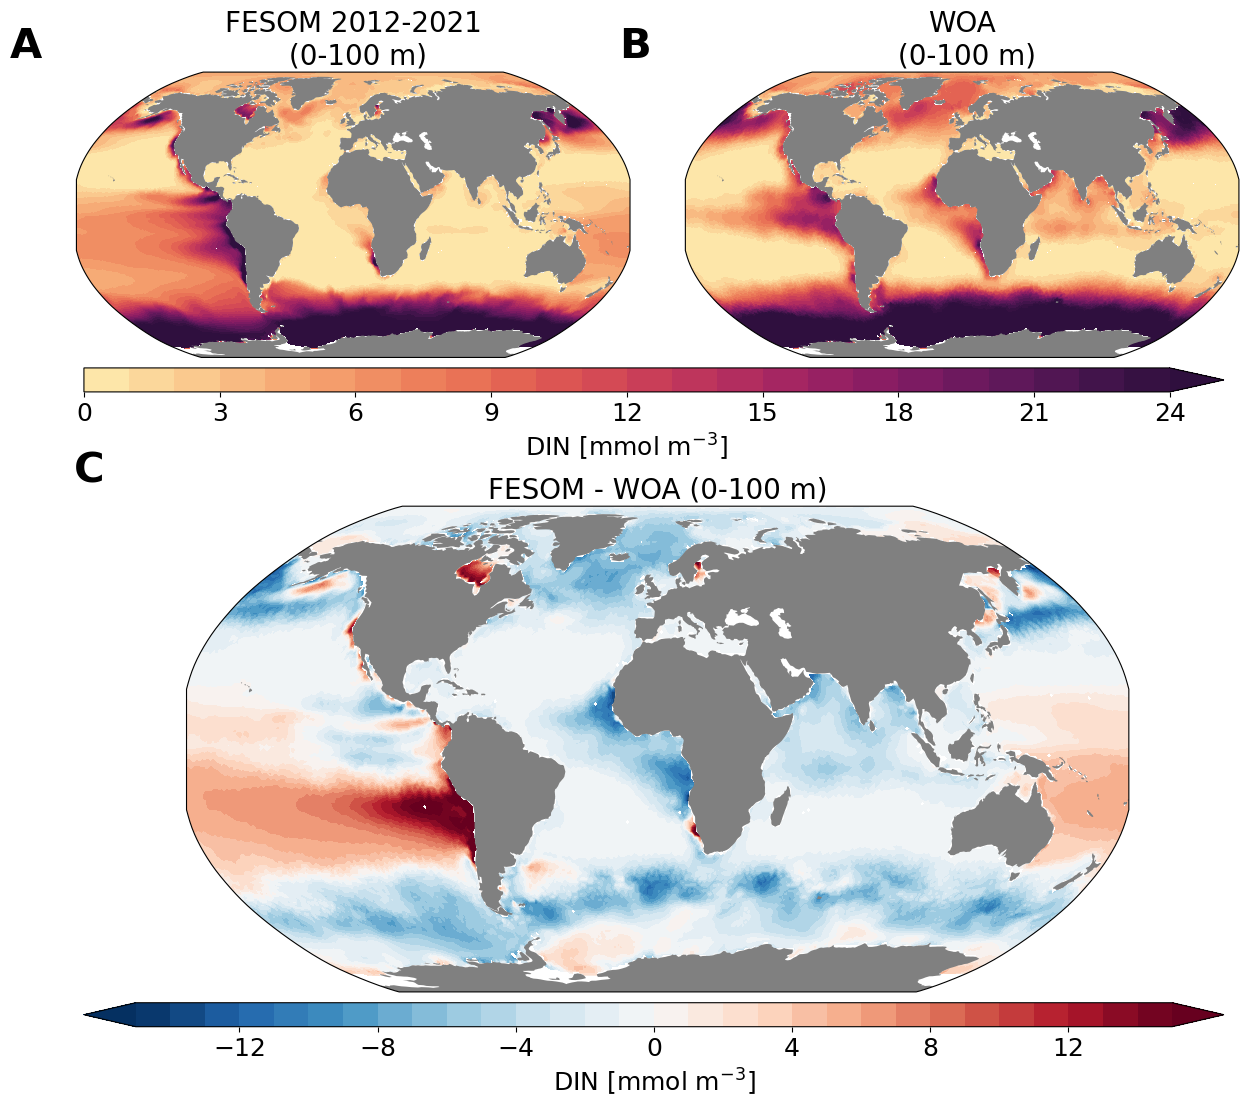


Original Taylor stats:
SDEV pred: 8.49564, ref: 8.85947
CRMS pred: 3.90017, ref: 0.00000
CORRCOEF: 0.89983

Normalized Taylor stats:
SDEV pred: 0.95893, ref: 1.00000
CRMS pred: 0.44023, ref: 0.00000
CORRCOEF: 0.89983


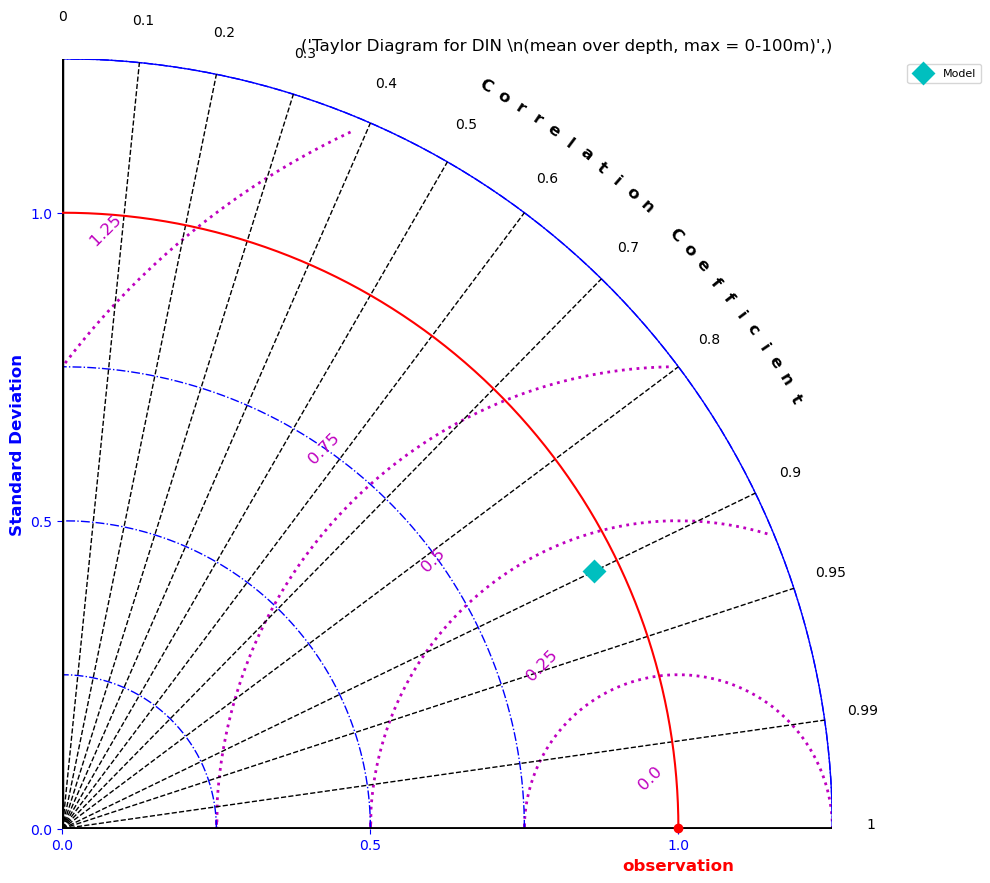

In [8]:
!jupyter nbconvert --to=python DIN_WOA.ipynb

from DIN_WOA import DINcomp
DINcomp(resultpath,savepath,mesh,ncfileDIN,first_year_maps,last_year,
               mapproj=mapproj,savefig=savefig,layerwise=layerwise,
               cmap=cmo.cm.matter,verbose=verbose,uplow=uplow)

### 2.1.3 DSi<a class="anchor" id="DSIMAP"></a>

[NbConvertApp] Converting notebook DSi_WOA.ipynb to python
[NbConvertApp] Writing 16763 bytes to DSi_WOA.py
***
Loading WOA file: /albedo/work/projects/MarESys/ogurses/input/corrected_input/woa13_all_i00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 9.9080, std = 18.4211, min = 0.0009, max = 80.3274
PISCES mean = 14.0232, std = 18.7146, min = 0.2021, max = 95.9487


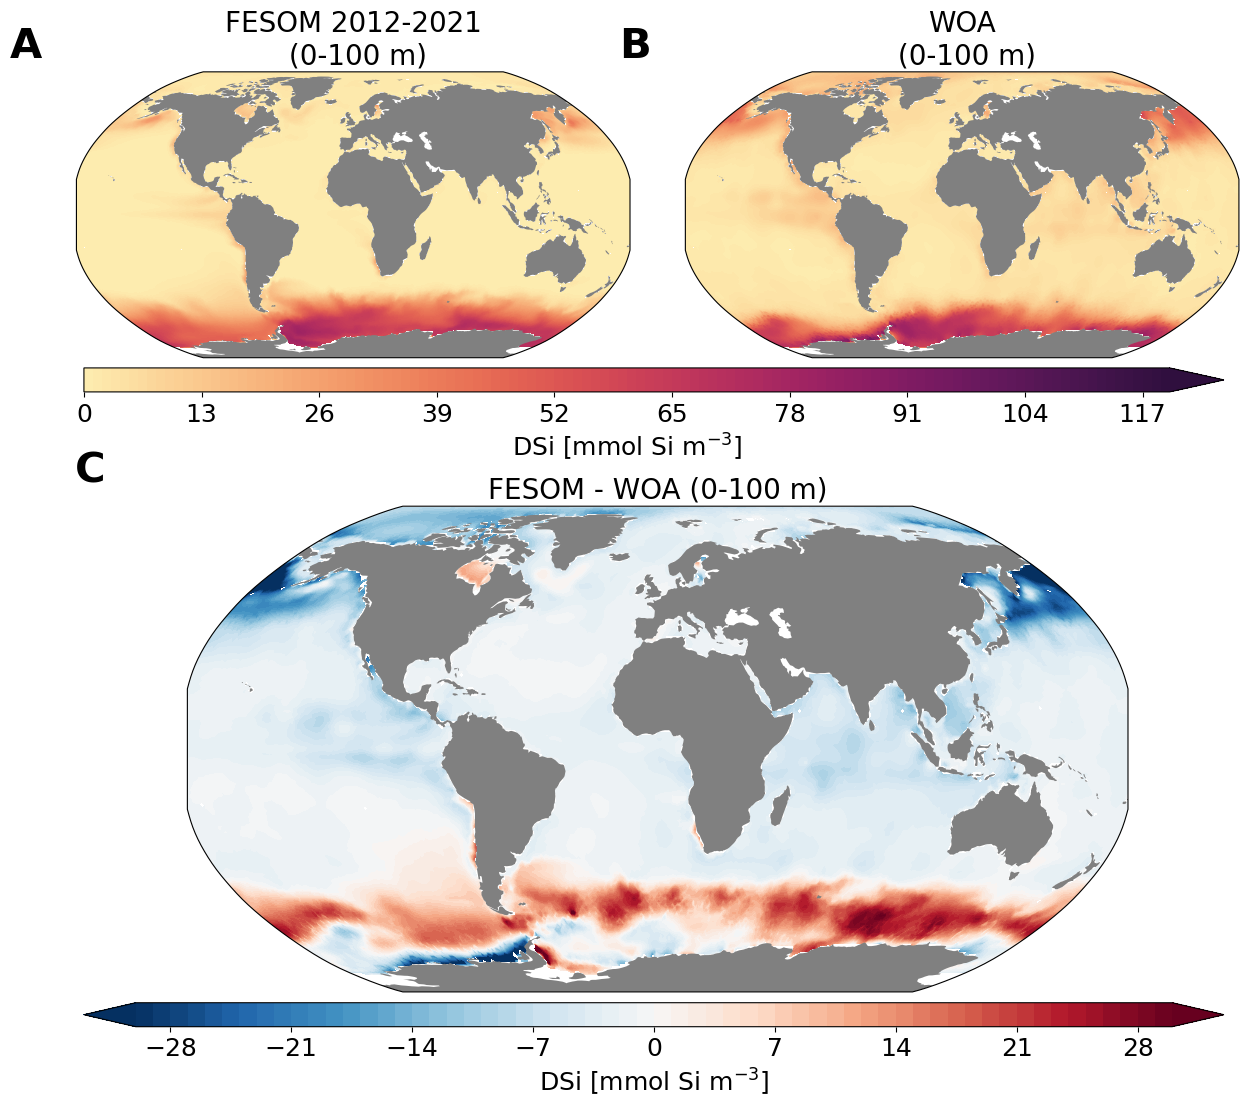


Original Taylor stats:
SDEV pred: 18.42114, ref: 18.71464
CRMS pred: 8.90326, ref: 0.00000
CORRCOEF: 0.88516

Normalized Taylor stats:
SDEV pred: 0.98432, ref: 1.00000
CRMS pred: 0.47574, ref: 0.00000
CORRCOEF: 0.88516


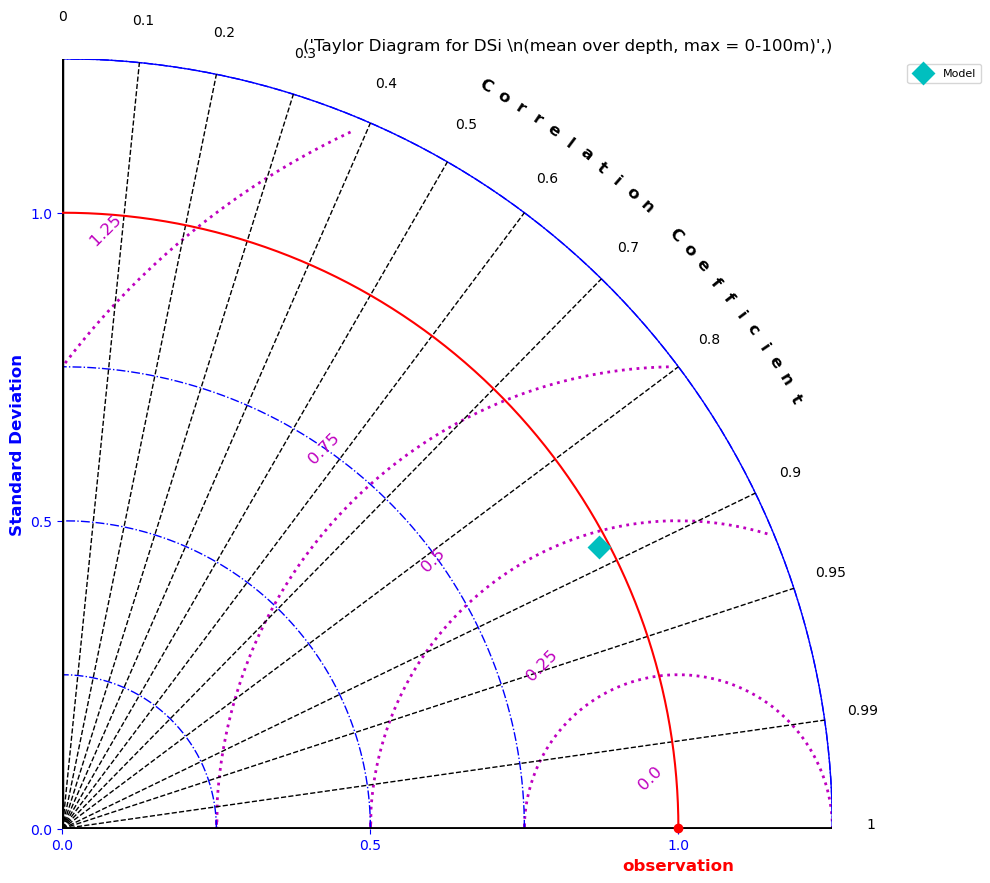

In [4]:
!jupyter nbconvert --to=python DSi_WOA.ipynb
from DSi_WOA import DSicomp

DSicomp(resultpath,savepath,mesh,ncfileDSi,first_year_maps,last_year,
        layerwise=layerwise,mapproj=mapproj,savefig=savefig,cmap=cmo.cm.matter,
           verbose=verbose,uplow=uplow)

### 2.1.4 DFe<a class="anchor" id="DFEMAP"></a>

[NbConvertApp] Converting notebook DFe_PISCES.ipynb to python
[NbConvertApp] Writing 17057 bytes to DFe_PISCES.py
[NbConvertApp] Converting notebook load_interp_PISCES.ipynb to python
[NbConvertApp] Writing 6732 bytes to load_interp_PISCES.py
***
Depth greater in FESOM (-6125.0) than in PISCES (-5500.0)
100m is too deep for climatology.
Please consider choosing max depth at -2.5!
***
Upper depth: 0.0, Lower depth: -100.0
Upper depth: 0.0, Lower depth: -100.0

FESOM mean = 0.4330, std = 0.7292, min = 0.0005, max = 13.5767
PISCES mean = 0.4411, std = 0.3686, min = 0.0049, max = 2.9243


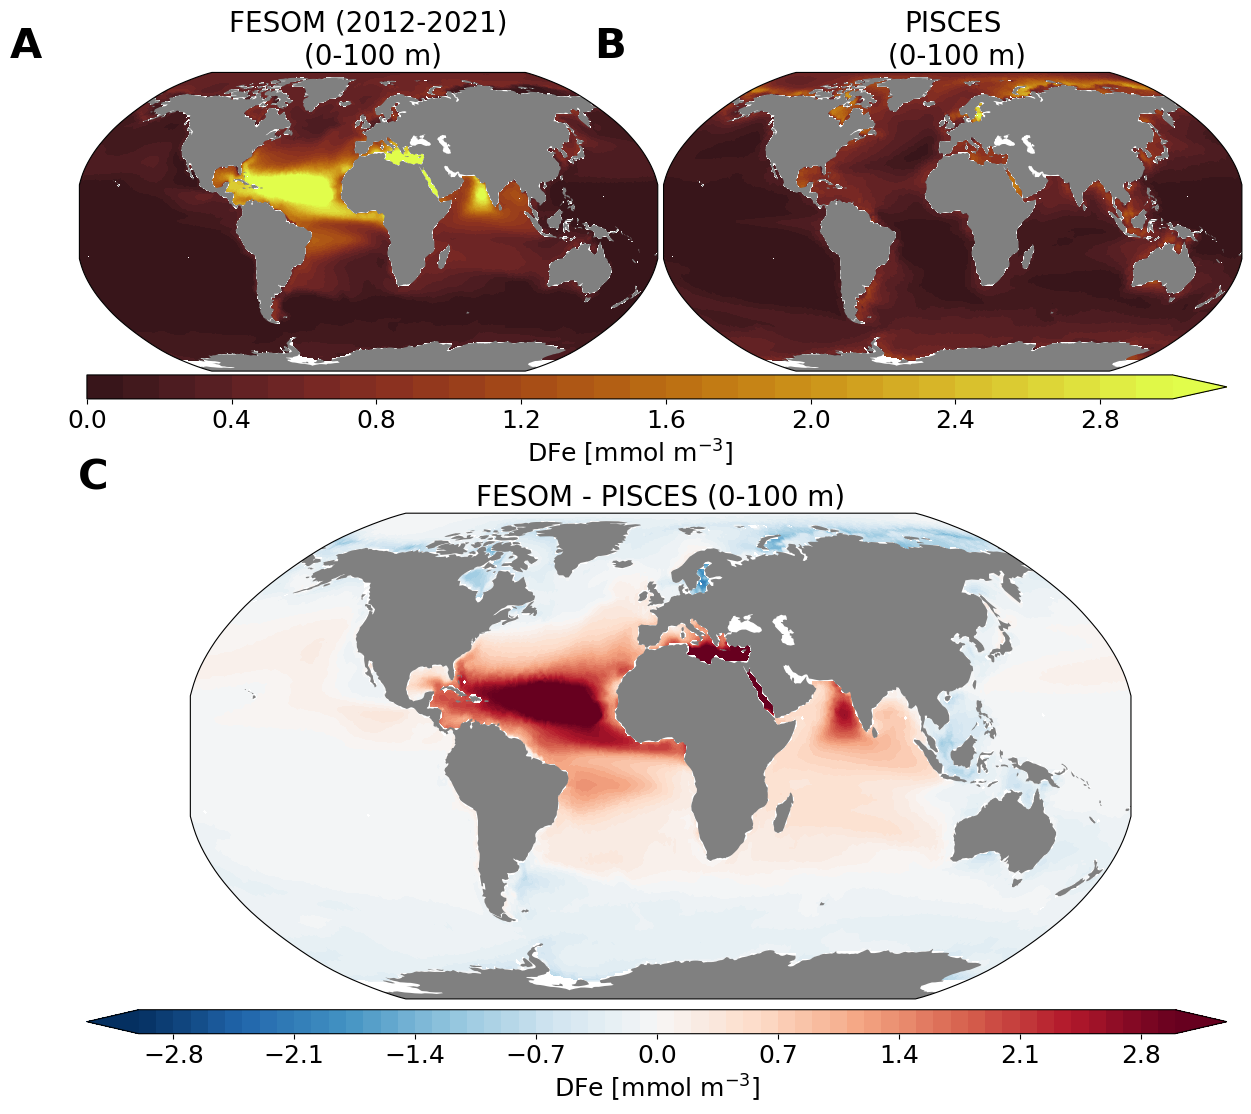


Original Taylor stats:
SDEV pred: 0.72918, ref: 0.36855
CRMS pred: 0.73408, ref: 0.00000
CORRCOEF: 0.23938

Normalized Taylor stats:
SDEV pred: 1.97849, ref: 1.00000
CRMS pred: 1.99177, ref: 0.00000
CORRCOEF: 0.23938
Adjust axis max to 2.5


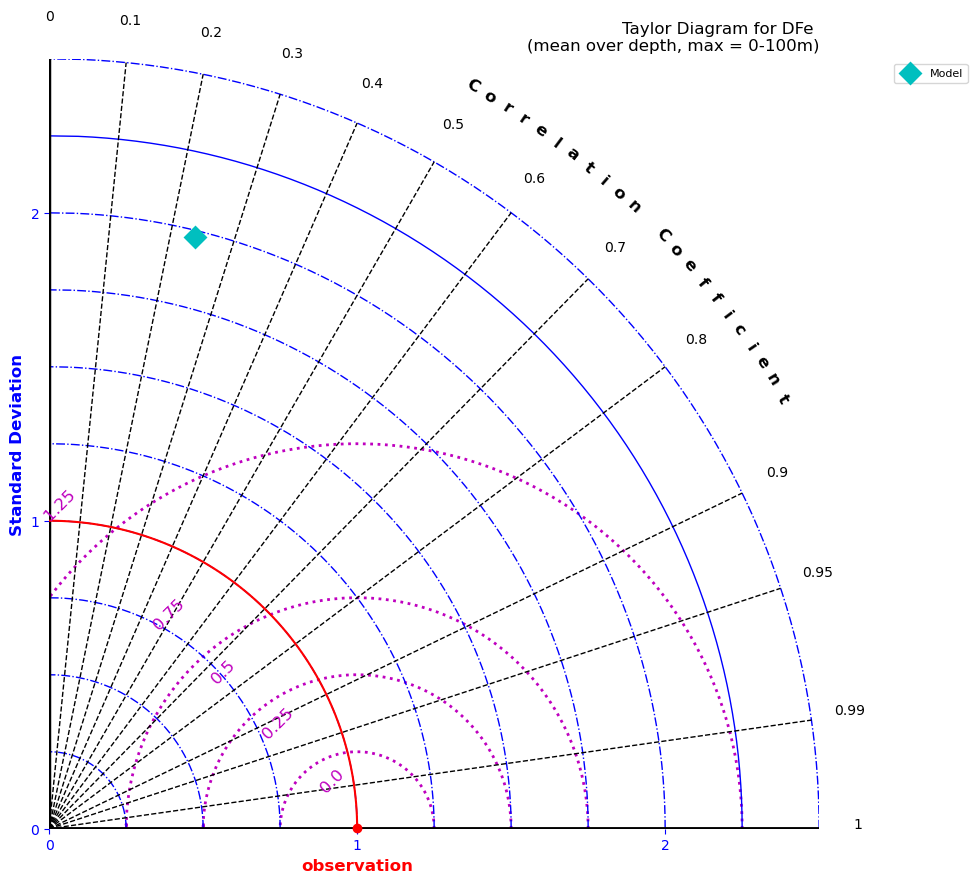

In [4]:
!jupyter nbconvert --to=python DFe_PISCES.ipynb
!jupyter nbconvert --to=python load_interp_PISCES.ipynb
from DFe_PISCES import DFecomp
from load_interp_PISCES import PISCESdata

DFecomp(resultpath,savepath,mesh,ncfileDFe_pisces,first_year_maps,last_year,mapproj=mapproj,savefig=savefig,
                 layerwise=layerwise,cmap = cmo.cm.solar)

## 2.2 Time-series<a class="anchor" id="BGCTS"></a>

### 2.2.1 DIN<a class="anchor" id="DINTS"></a>

[NbConvertApp] Converting notebook DIN_timeseries.ipynb to python
[NbConvertApp] Writing 19164 bytes to DIN_timeseries.py
calculating time series...
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
calculation done.
plotting...
plotting done.


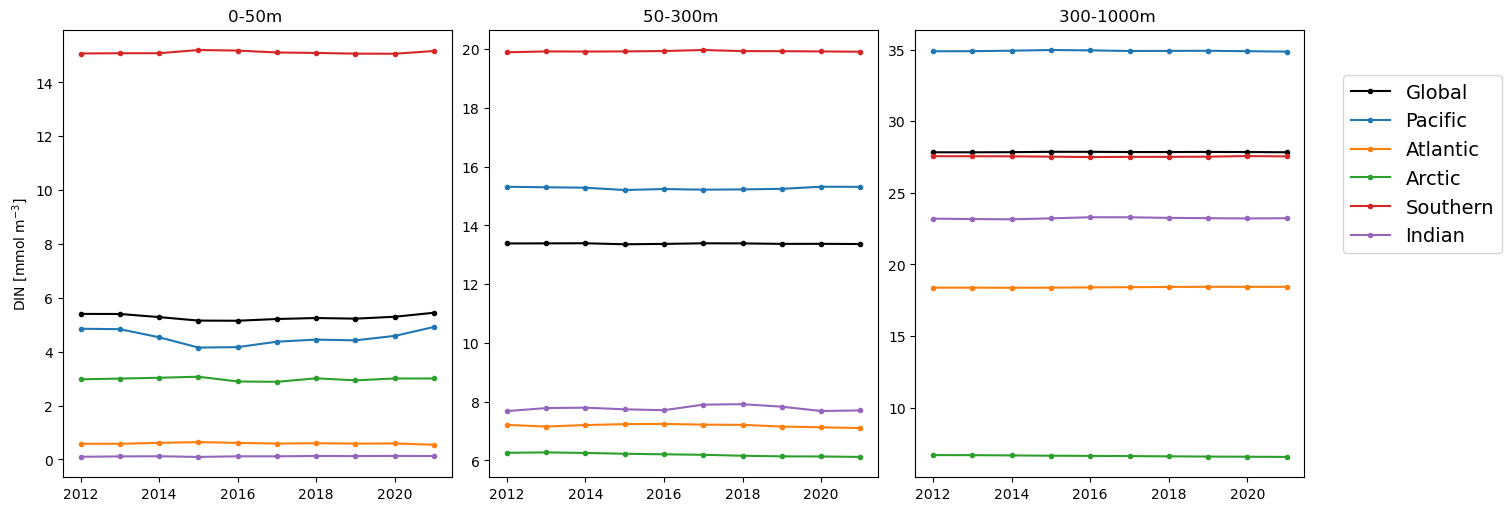

In [5]:
!jupyter nbconvert --to=python DIN_timeseries.ipynb
from DIN_timeseries import DIN_timeseries

DIN_timeseries(resultpath,savepath,mesh,first_year,last_year,savefig=savefig,regional='all')

### 2.2.2 DSi<a class="anchor" id="DSITS"></a>

[NbConvertApp] Converting notebook DSi_timeseries.ipynb to python
[NbConvertApp] Writing 19079 bytes to DSi_timeseries.py
calculating time series...
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
calculation done.
plotting...
plotting done.


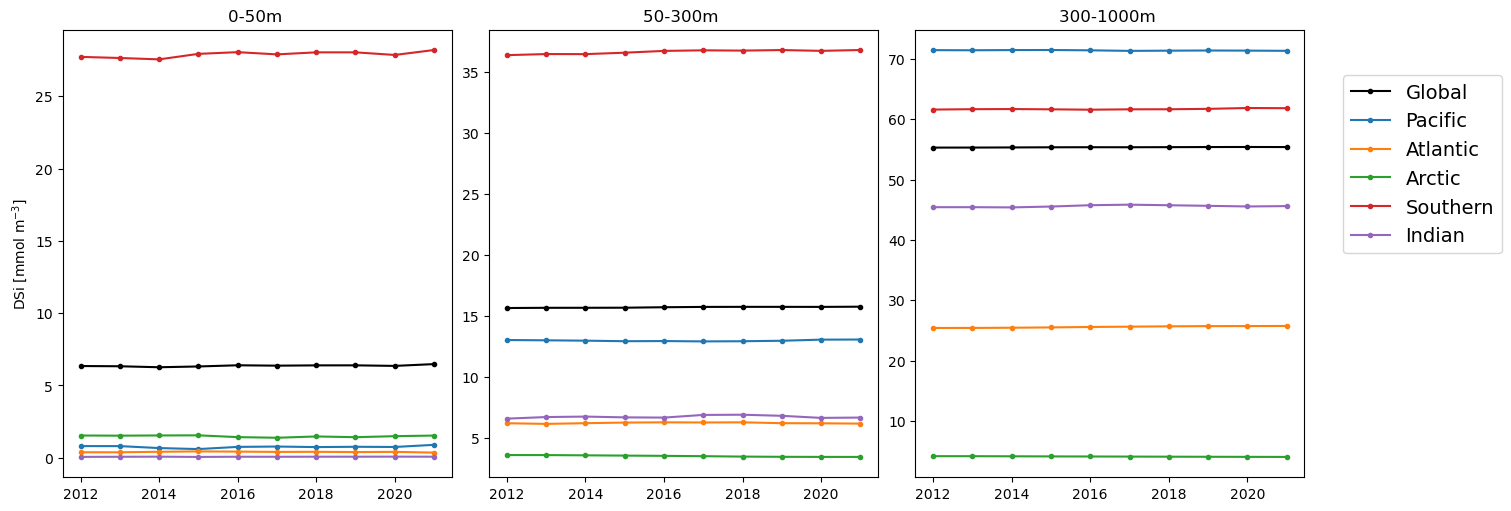

In [6]:
!jupyter nbconvert --to=python DSi_timeseries.ipynb
from DSi_timeseries import DSi_timeseries

DSi_timeseries(resultpath,savepath,mesh,first_year,last_year,savefig=savefig,regional='all')

### 2.2.3 DFe<a class="anchor" id="DFETS"></a>

[NbConvertApp] Converting notebook DFe_timeseries.ipynb to python
[NbConvertApp] Writing 19119 bytes to DFe_timeseries.py
calculating time series...
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
Upper depth: 0.0, Lower depth: -50.0
Upper depth: -50.0, Lower depth: -280.0
Upper depth: -280.0, Lower depth: -1040.0
calculation done.
plotting...
plotting done.


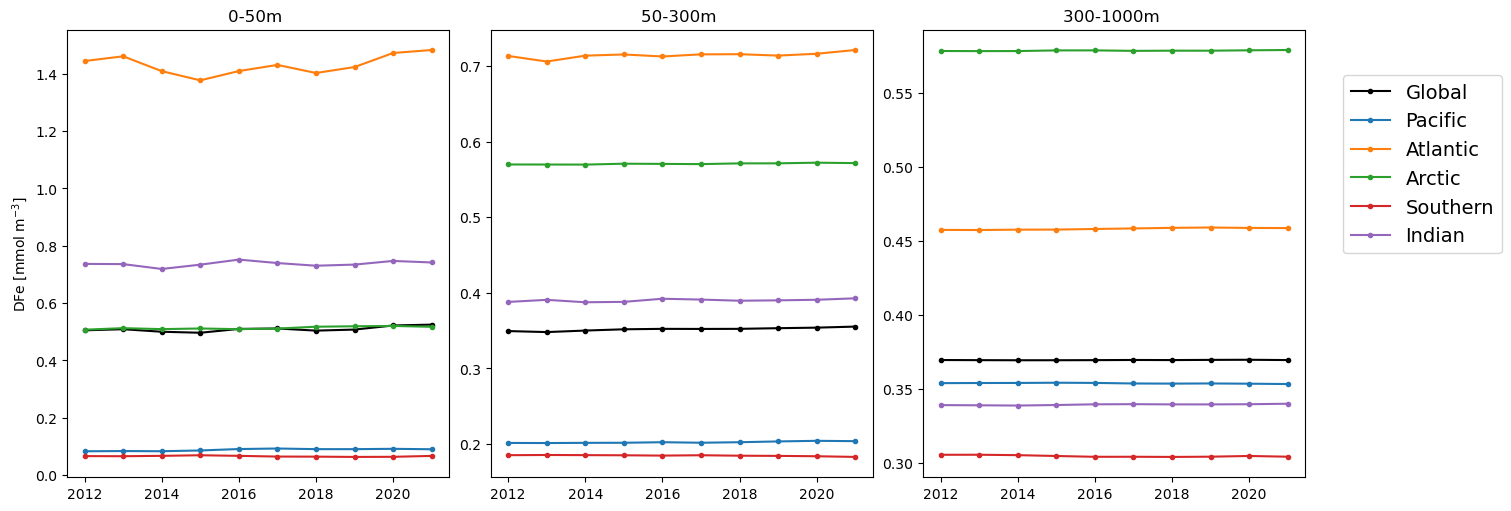

In [7]:
!jupyter nbconvert --to=python DFe_timeseries.ipynb
from DFe_timeseries import DFe_timeseries

DFe_timeseries(resultpath,savepath,mesh,first_year,last_year,savefig=savefig,regional='all')

## 2.3 Profiles<a class="anchor" id="BGCPRO"></a>

[NbConvertApp] Converting notebook DO2_profiles.ipynb to python
[NbConvertApp] Writing 8883 bytes to DO2_profiles.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa18_all_o00_01_mmol_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)


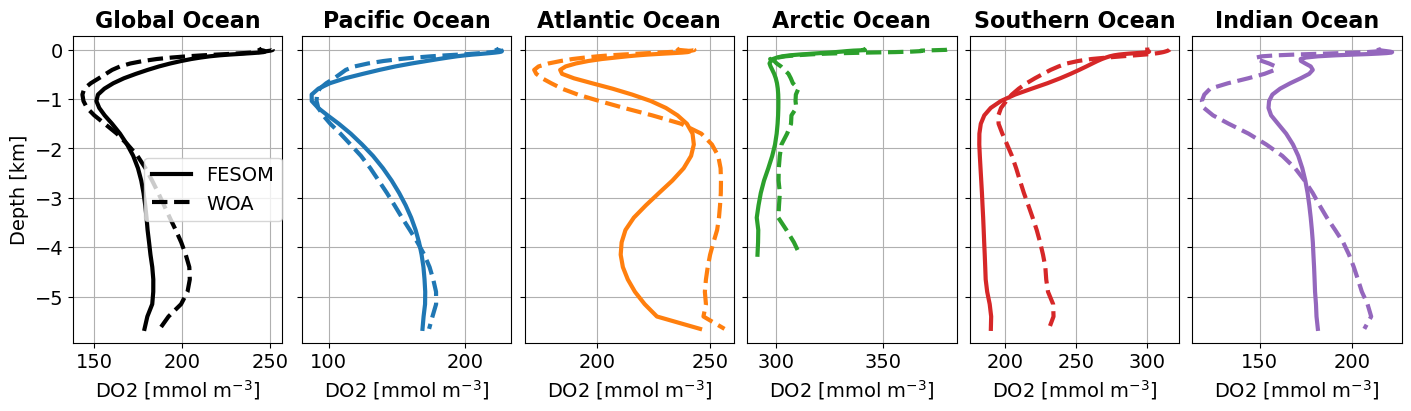

In [4]:
!jupyter nbconvert --to=python DO2_profiles.ipynb
from DO2_profiles import DO2_profile

DO2_profile(resultpath,savepath,mesh,ncfileDO2,first_year_maps,last_year,
                 savefig=savefig, regional=True)

[NbConvertApp] Converting notebook Nutrients_profiles.ipynb to python
[NbConvertApp] Writing 20564 bytes to Nutrients_profiles.py
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa13_all_n00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
***
Loading WOA file: /albedo/work/projects/p_pool_recom/eval/data/woa13_all_i00_01_fesom2.nc
***
***
Depth greater in FESOM (-6125.0) than in WOA (-5500.0)
***
Depth greater in FESOM (-6125.0) than in PISCES (-5500.0)


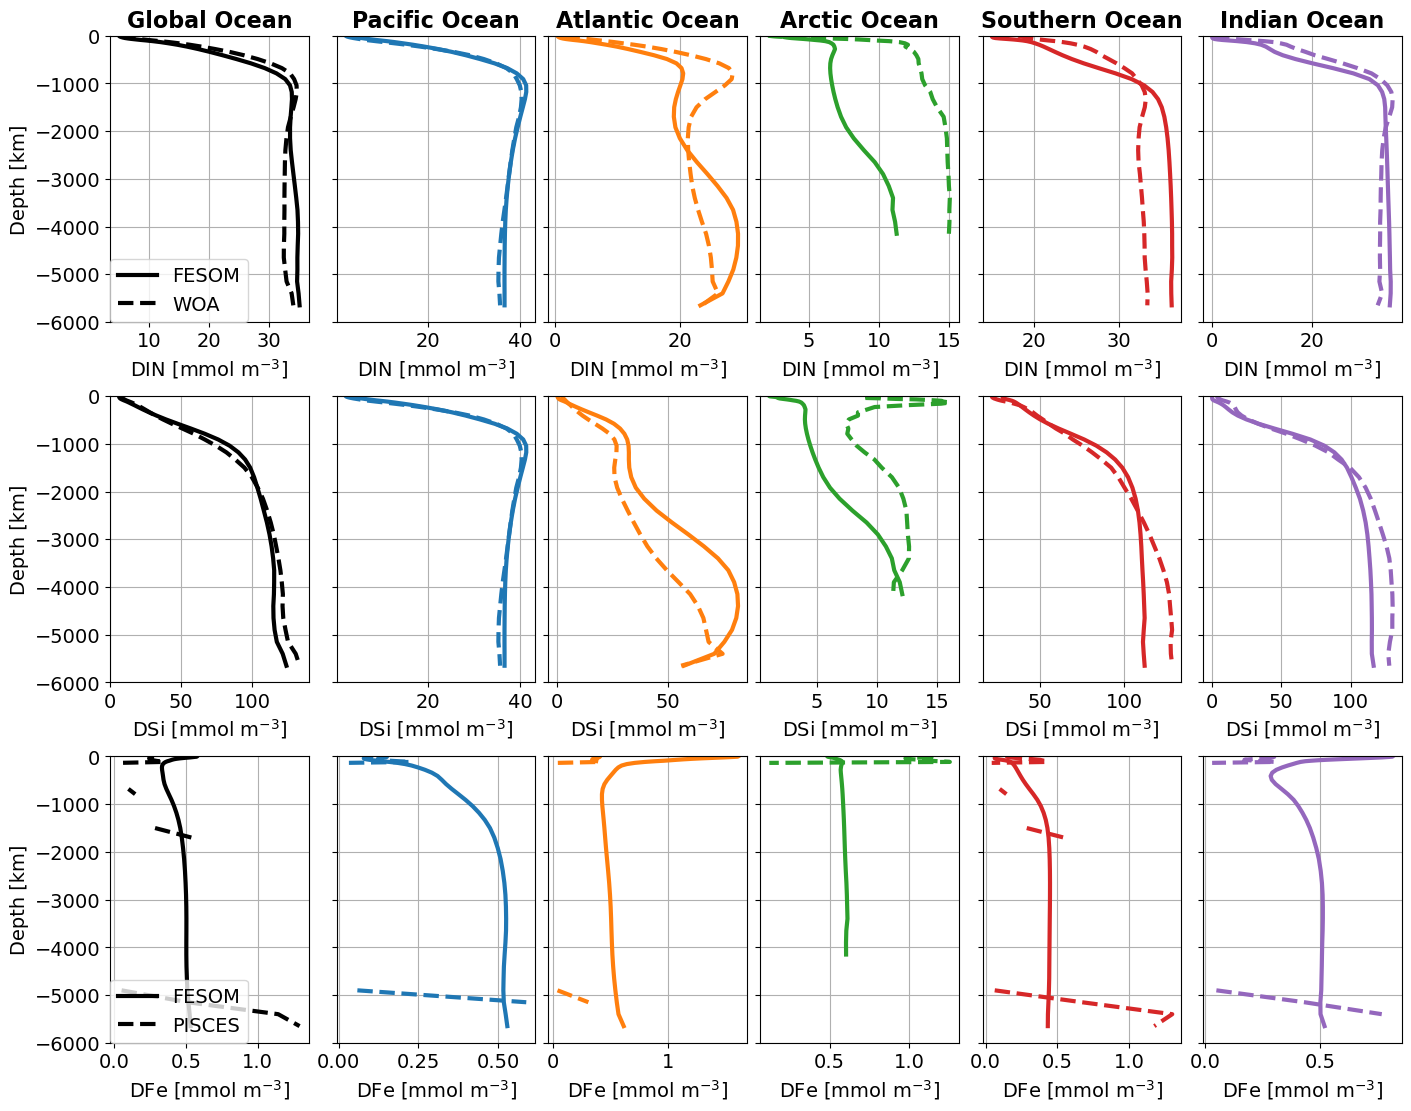

In [6]:
!jupyter nbconvert --to=python Nutrients_profiles.ipynb
from Nutrients_profiles import Nut_profile

Nut_profile(resultpath,savepath,mesh,ncfileDSi,ncfileDIN,ncfileDFe_pisces,first_year_maps,last_year,
                 savefig=savefig, regional=True)

# Save notebook as html

In [ ]:
%%javascript
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')
%autosave 2
!jupyter nbconvert $nb_name --output-dir=$htmlpath --to html --no-input